In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/quora-qs-ans/Quora-QuAD.jsonl


In [2]:
pip install transformers[torch] tokenizers datasets evaluate rouge_score sentencepiece huggingface_hub --upgrade


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.2/417.2 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 67.3 MB/s eta 0:00:00:00:0100:01
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=3831879f4719968b5e0775f1035b3268227408a641b410e403bc967b46c9e3a7
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.23.4
    Uninstalling huggingface-hub-0.23.4:
      Successfully uninstalled huggingface-hub-0.23.4
  Attempting uninstall: transformers
    Found existing installation: transformers 4.42.3
    Uninstalling transformers-4.42.3:
      Successfu

In [3]:
import json
def read_jsonl_to_dataframe(file_path):
    """
    Reads a JSONL file and converts it into a pandas DataFrame.
    
    Parameters:
    file_path (str): Path to the JSONL file to be read.

    Returns:
    pandas.DataFrame: DataFrame containing the data from the JSONL file.
    """
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            data.append(json.loads(line))
    
    return pd.DataFrame(data)

In [4]:
file_path = '/kaggle/input/quora-qs-ans/Quora-QuAD.jsonl'
df = read_jsonl_to_dataframe(file_path)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56402 entries, 0 to 56401
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  56402 non-null  object
 1   answer    56402 non-null  object
dtypes: object(2)
memory usage: 881.4+ KB


In [6]:
df.describe()

,question,answer
count,56402,56402
unique,3234,54726
top,Would Hillary Clinton have made a better Presi...,No\n
freq,106,89


In [7]:
df.head()

,question,answer
0,Why whenever I get in the shower my girlfriend...,Isn’t it awful? You would swear that there was...
1,"What is a proxy, and how can I use one?",A proxy server is a system or router that prov...
2,"What song has the lyrics ""someone left the cak...",MacArthur's Park\n
3,I am the owner of an adult website called http...,Don't let apps that are liers put adds on your...
4,Does the Bible mention anything about a place ...,St. John in the book of Revelation mentions an...


In [8]:
df.shape

(56402, 2)

In [9]:
# Count the number of duplicate rows based on the 'question' and 'answer' columns
num_duplicates = df.duplicated(subset=['question', 'answer']).sum()
print(f"Number of duplicate rows: {num_duplicates}")

Number of duplicate rows: 1220


In [10]:
df.drop_duplicates(subset=['question', 'answer'], inplace=True)


In [11]:
df.shape

(55182, 2)

In [12]:
# Count the number of rows with null values in 'question' or 'answer'
num_nulls = df[['question', 'answer']].isnull().any(axis=1).sum()
print(f"Number of rows with null values: {num_nulls}") #As no null value we do not need to remove them

Number of rows with null values: 0


In [13]:
df1=df.copy()
# Calculate the number of words in each question and answer
df1['question_word_count'] = df['question'].apply(lambda x: len(x.split()))
df1['answer_word_count'] = df['answer'].apply(lambda x: len(x.split()))

In [14]:
df1.head()

,question,answer,question_word_count,answer_word_count
0,Why whenever I get in the shower my girlfriend...,Isn’t it awful? You would swear that there was...,12,15
1,"What is a proxy, and how can I use one?",A proxy server is a system or router that prov...,10,286
2,"What song has the lyrics ""someone left the cak...",MacArthur's Park\n,13,2
3,I am the owner of an adult website called http...,Don't let apps that are liers put adds on your...,24,117
4,Does the Bible mention anything about a place ...,St. John in the book of Revelation mentions an...,12,31


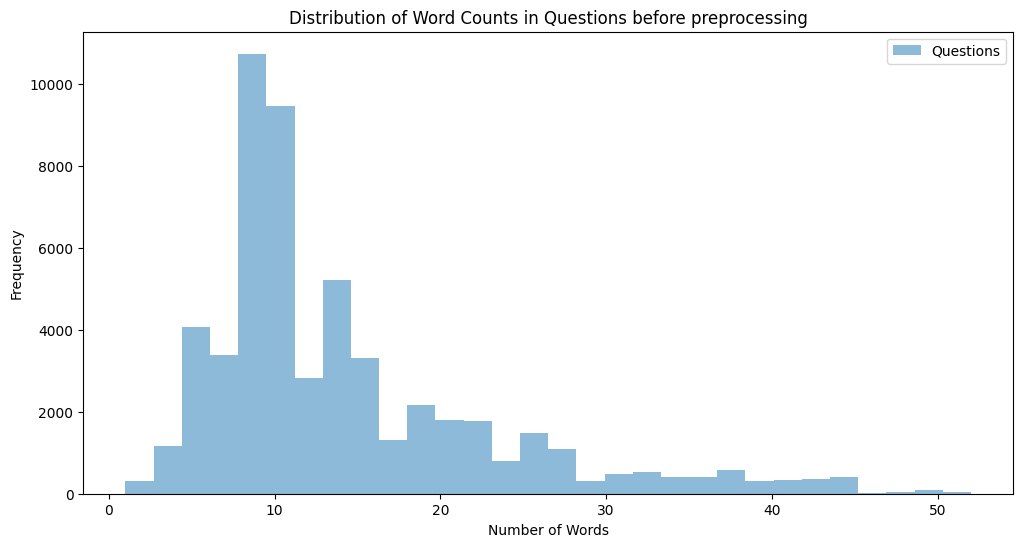

In [15]:
import matplotlib.pyplot as plt

# Plot the distribution of word counts for questions
plt.figure(figsize=(12, 6))
plt.hist(df1['question_word_count'], bins=30, alpha=0.5, label='Questions')
# plt.hist(df['answer_word_count'], bins=30, alpha=0.5, label='Answers')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Word Counts in Questions before preprocessing')
plt.legend(loc='upper right')
plt.show()

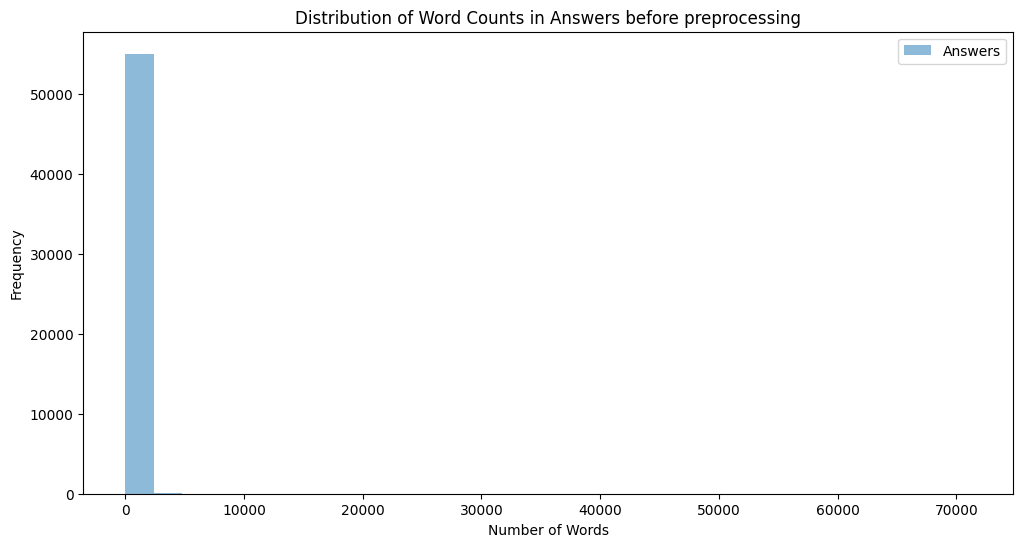

In [16]:
import matplotlib.pyplot as plt

# Plot the distribution of word counts for questions
plt.figure(figsize=(12, 6))
# plt.hist(df1['question_word_count'], bins=30, alpha=0.5, label='Questions')
plt.hist(df1['answer_word_count'], bins=30, alpha=0.5, label='Answers')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Word Counts in Answers before preprocessing')
plt.legend(loc='upper right')
plt.show()

In [17]:
import numpy as np

# Calculate the 98th percentile
upper_limit = np.percentile(df1['answer_word_count'], 98)
print(f"98th percentile of answer word count: {upper_limit}")

# Filter the dataset to exclude outliers
filtered_df1 = df1[df1['answer_word_count'] <= upper_limit]

98th percentile of answer word count: 779.0


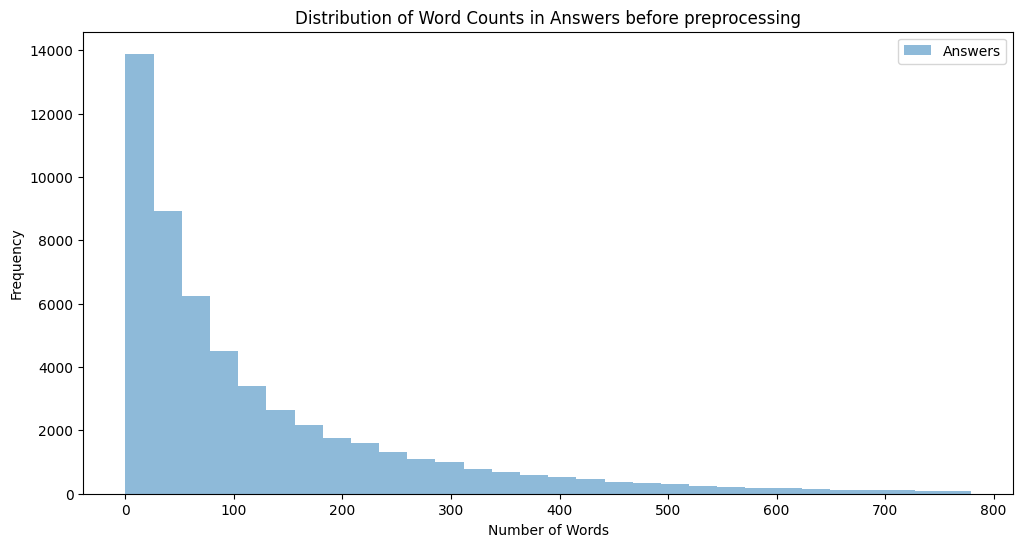

In [18]:
import matplotlib.pyplot as plt

# Plot the distribution of word counts for answers (filtered)
plt.figure(figsize=(12, 6))
plt.hist(filtered_df1['answer_word_count'], bins=30, alpha=0.5, label='Answers')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Word Counts in Answers before preprocessing')
plt.legend(loc='upper right')
plt.show()


In [19]:
import regex as re
# Count HTML codes
html_pattern = re.compile(r'<.*?>')
num_html_codes = df.apply(lambda row: len(html_pattern.findall(row['question']) + html_pattern.findall(row['answer'])), axis=1).sum()
print(f"Number of HTML codes: {num_html_codes}")


Number of HTML codes: 495


In [20]:

# Function to check if a string contains HTML tags
def contains_html(text):
    return bool(html_pattern.search(text))

# Filter rows containing HTML tags
html_rows = df[df.apply(lambda row: contains_html(row['question']) or contains_html(row['answer']), axis=1)]

print("\nExample rows containing HTML tags:")
html_rows.head()


Example rows containing HTML tags:


,question,answer
267,f:\N \mapsto \N,"Yes there is, and yes it’s unique.\n Let’s sta..."
558,What is a do-follow backlink?,"""nofollow"" and ""dofollow"" are link attributes ..."
1390,How do you meet the right people to trade bitc...,Bitcoin trading can be extremely profitable fo...
2242,How fast could the US Air Force SR-71 Blackbir...,Very EASY answer!!! The exact envelope of the ...
3261,What could have been done to make season 7 and...,Gonna echo [LINKED_TEXT: Kelsey L. Hayes] [URL...


In [21]:
# Remove HTML codes
df['question'] = df['question'].apply(lambda x: re.sub(html_pattern, '', x))
df['answer'] = df['answer'].apply(lambda x: re.sub(html_pattern, '', x))

In [22]:
# Count URLs
url_pattern = re.compile(r'http\S+|www.\S+')
num_urls = df.apply(lambda row: len(url_pattern.findall(row['question']) + url_pattern.findall(row['answer'])), axis=1).sum()
print(f"Number of URLs: {num_urls}")


Number of URLs: 26573


In [23]:
# Function to check if a string contains URL
def contains_url(text):
    return bool(url_pattern.search(text))

# Filter rows containing HTML tags
url_rows = df[df.apply(lambda row: contains_url(row['question']) or contains_url(row['answer']), axis=1)]

print("\nExample rows containing url tags:")
url_rows.head()


Example rows containing url tags:


,question,answer
3,I am the owner of an adult website called http...,Don't let apps that are liers put adds on your...
12,What are the best ways to invest money?,World safest investment in buy Plots at hydera...
16,Can you take control of your blood sugar?,Hey there.What if I told you that you could lo...
23,What are some little known benefits to leasing...,"According to me, Yes! Because It allows me to ..."
26,"What is a proxy, and how can I use one?",Think if you are using the internet directly a...


In [24]:
import emoji

# Define a function to check if a character is an emoji
def is_emoji(char):
    return char in emoji.EMOJI_DATA

# Count emojis
num_emojis = df.apply(lambda row: sum([1 for char in row['question'] if is_emoji(char)]) + sum([1 for char in row['answer'] if is_emoji(char)]), axis=1).sum()
print(f"Number of emojis: {num_emojis}")


Number of emojis: 5520


In [25]:
# Filter rows containing emojis
emoji_rows = df[df.apply(lambda row: any(is_emoji(char) for char in row['question']) or any(is_emoji(char) for char in row['answer']), axis=1)]

print("Rows containing emojis:")
emoji_rows.head()

Rows containing emojis:


,question,answer
6,The justice department has told the state of M...,🤣🤣🤣 its not much different than states legaliz...
165,Can an unmarried couple stay in Coimbatore?,Why not ! ‍♂️\n
172,What is served as breakfast in your country?,Being north Indian Parathas are our staple\n b...
325,Why are Tempurpedic beds so expensive?,In terms of brand reliability - Sleepwell >= S...
337,What is the best love story people can come up...,Their eyes did the talking in the pin drop sil...


In [26]:
# Define a function to replace emojis with their meanings
def replace_emoji_with_meaning(text):
    return emoji.demojize(text)
# Replace emojis with their meanings
df['question'] = df['question'].apply(replace_emoji_with_meaning)
df['answer'] = df['answer'].apply(replace_emoji_with_meaning)

In [27]:
df['answer'][6]

':rolling_on_the_floor_laughing::rolling_on_the_floor_laughing::rolling_on_the_floor_laughing: its not much different than states legalizing Marijuana for their residents..whats good for the goose..is good for the gander :winking_face::winking_face:\n'

In [28]:
from nltk.corpus import stopwords

# Load stopwords
stop = set(stopwords.words('english'))

# Count stopwords
num_stopwords = df.apply(lambda row: sum([1 for word in row['question'].split() if word in stop] + [1 for word in row['answer'].split() if word in stop]), axis=1).sum()
print(f"Number of stopwords: {num_stopwords}")

Number of stopwords: 3601066


In [29]:
# Remove stopwords
df['question'] = df['question'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))
df['answer'] = df['answer'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))

In [30]:
import string

# Count punctuation
num_punctuations = df.apply(lambda row: sum([1 for char in row['question'] if char in string.punctuation] + [1 for char in row['answer'] if char in string.punctuation]), axis=1).sum()
print(f"Number of punctuation marks: {num_punctuations}")

Number of punctuation marks: 1824989


In [31]:
# Remove punctuation
df['question'] = df['question'].apply(lambda x: ''.join(char for char in x if char not in string.punctuation))
df['answer'] = df['answer'].apply(lambda x: ''.join(char for char in x if char not in string.punctuation))

In [43]:
df['question'] = df['question'].str.lower()
df['answer'] = df['answer'].str.lower()

In [32]:
df1=df.copy()
# Calculate the number of words in each question and answer
df1['question_word_count'] = df['question'].apply(lambda x: len(x.split()))
df1['answer_word_count'] = df['answer'].apply(lambda x: len(x.split()))

In [33]:
df1.head()

,question,answer,question_word_count,answer_word_count
0,Why whenever I get shower girlfriend want join,Isn’t awful You would swear wasn’t enough hot ...,8,11
1,What proxy I use one,A proxy server system router provides gateway ...,5,161
2,What song lyrics someone left cake rain,MacArthurs Park,7,2
3,I owner adult website called httpsmatureanallo...,Dont let apps liers put adds site Like ones sa...,16,69
4,Does Bible mention anything place between heav...,St John book Revelation mentions address schol...,8,19


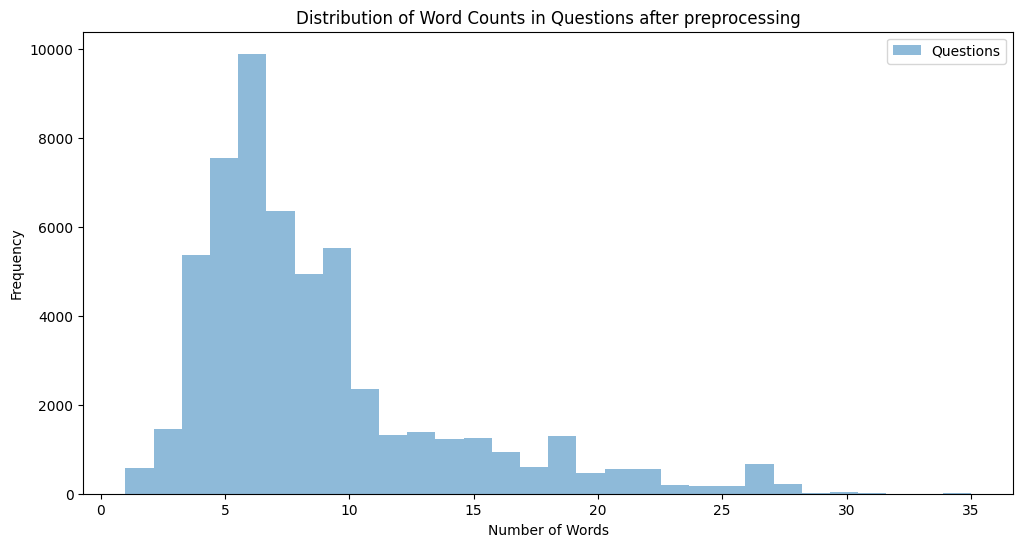

In [34]:
import matplotlib.pyplot as plt

# Plot the distribution of word counts for questions
plt.figure(figsize=(12, 6))
plt.hist(df1['question_word_count'], bins=30, alpha=0.5, label='Questions')
# plt.hist(df['answer_word_count'], bins=30, alpha=0.5, label='Answers')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Word Counts in Questions after preprocessing')
plt.legend(loc='upper right')
plt.show()

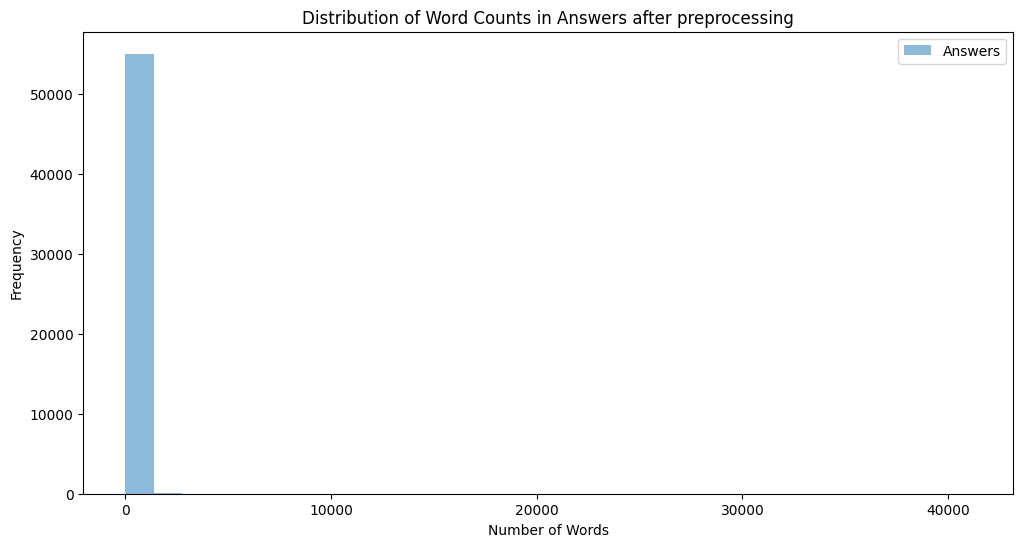

In [35]:
import matplotlib.pyplot as plt

# Plot the distribution of word counts for questions
plt.figure(figsize=(12, 6))
# plt.hist(df1['question_word_count'], bins=30, alpha=0.5, label='Questions')
plt.hist(df1['answer_word_count'], bins=30, alpha=0.5, label='Answers')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Word Counts in Answers after preprocessing')
plt.legend(loc='upper right')
plt.show()

In [36]:
import numpy as np

# Calculate the 98th percentile
upper_limit = np.percentile(df1['answer_word_count'], 98)
print(f"98th percentile of answer word count: {upper_limit}")

# Filter the dataset to exclude outliers
filtered_df1 = df1[df1['answer_word_count'] <= upper_limit]

98th percentile of answer word count: 477.0


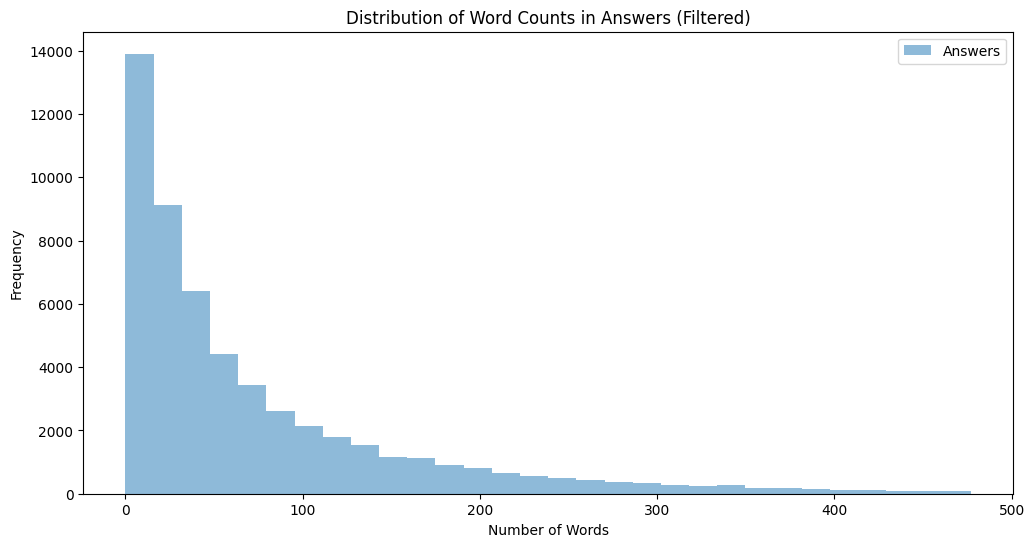

In [37]:
import matplotlib.pyplot as plt

# Plot the distribution of word counts for answers (filtered)
plt.figure(figsize=(12, 6))
plt.hist(filtered_df1['answer_word_count'], bins=30, alpha=0.5, label='Answers')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Word Counts in Answers (Filtered)')
plt.legend(loc='upper right')
plt.show()


In [38]:
# Identify outliers
outliers = df1[df1['answer_word_count'] > upper_limit]

# Display outliers
outliers

,question,answer,question_word_count,answer_word_count
32,Why conspiracy theorists need believe theories,For many diverse reasons For one thing minds d...,6,524
139,How I invest 20000 USD best possible way,I choose invest Stock Market amount Guide inve...,8,613
244,What CEO startup do What typical day look like...,The 10 Roles Startup CEO The measure time spen...,16,591
300,Have ever found kid wasn’t getting paternity t...,It happened me I’m staying anonymous obvious r...,13,819
412,Why everyone hate Captain Marvel squeezing guy...,Well looks like it’s time again Short answer B...,11,495
...,...,...,...,...
56133,What best way preparing GATE CSE,A brief me I given GATE twice Once 4th year B ...,6,563
56152,What different styles photography there,If love passionate photography nothing beat ex...,5,495
56158,Is becoming doctor financially worth it,The grim reality working healthcare Being heal...,6,554
56275,Do female users get harassed questions answers...,I don’t write way “angry men” expect woman wri...,9,609


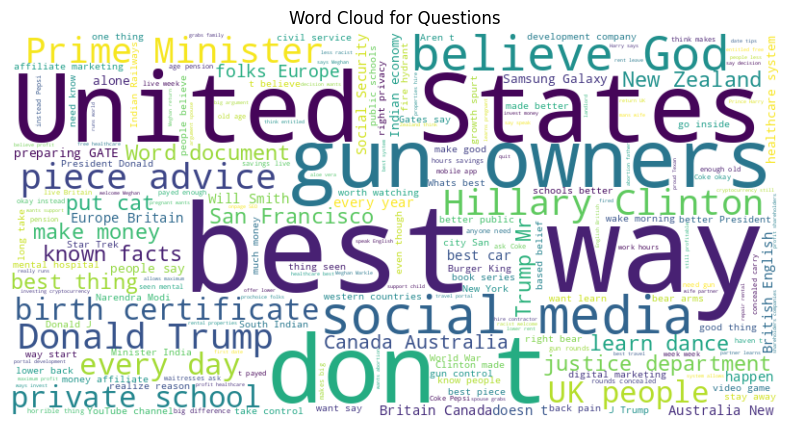

In [39]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all questions and answers into single strings
all_questions = ' '.join(df1['question'])

# Create word cloud for questions
wordcloud_questions = WordCloud(width=800, height=400, background_color='white').generate(all_questions)



# Plot the word cloud for questions
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_questions, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Questions')
plt.show()


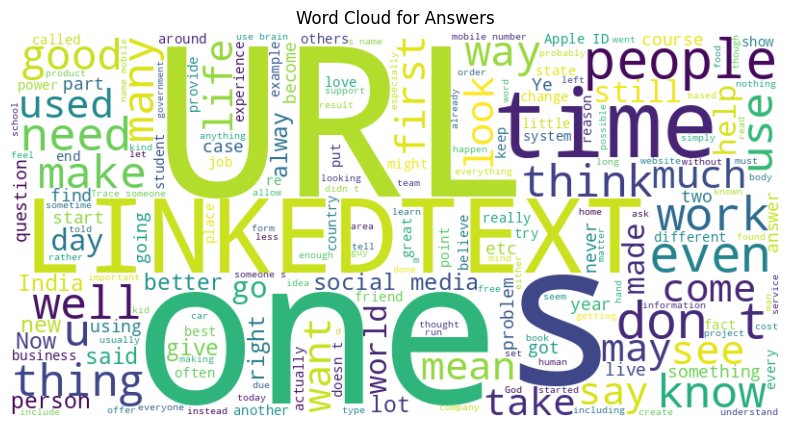

In [40]:
all_answers = ' '.join(df1['answer'])
# Create word cloud for answers
wordcloud_answers = WordCloud(width=800, height=400, background_color='white').generate(all_answers)
# Plot the word cloud for answers
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_answers, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Answers')
plt.show()

In [41]:
from collections import Counter
# Calculate word frequency
question_word_count = Counter(all_questions.split())


# Print the most common words
print("Most common words in questions:")
for word, count in question_word_count.most_common(10):
    print(f"{word}: {count}")



Most common words in questions:
What: 19460
I: 10914
How: 8043
Why: 7270
Is: 4013
best: 3990
would: 2950
get: 2699
people: 2505
If: 2378


In [42]:
answer_word_count = Counter(all_answers.split())
print("\nMost common words in answers:")
for word, count in answer_word_count.most_common(10):
    print(f"{word}: {count}")


Most common words in answers:
I: 78250
The: 37057
URL: 23746
one: 21042
LINKEDTEXT: 20381
like: 19850
would: 18244
time: 17213
It: 17154
people: 16722
